In [32]:
from kbmodpy import kbmod as kb
from trajectoryFiltering import *
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [33]:
path = '../../HITS/test_35/4,6tempExp/new_header/'

In [34]:
files = os.listdir(path)

In [35]:
files.sort()
files = [path+f for f in files]
files = files[:4]
files

['../../HITS/test_35/4,6tempExp/new_header/v410913-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v410969-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411019-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411053-fg.fits']

In [36]:
images = [kb.layered_image(f) for f in files]

Object Generation Parameters

In [37]:
p = kb.psf(1.5)
object_count = 10
x_range = (5,3650)
y_range = (5, 3650)
angle_range = (0.1, 0.5)
velocity_range = (1900, 2900)
flux_range = (800, 4000)

Search Parameters

In [38]:
min_observations = 3
angle_steps = 120
velocity_steps = 100
search_margin = 1.2

In [39]:
print(angle_range[1]-angle_range[0])
print(velocity_range[1]-velocity_range[0])

0.4
1000


Generate Random trajectories within bounds

In [40]:
results_key = []
for _ in range(object_count):
    traj = kb.trajectory()
    traj.x = int(rd.uniform(*x_range))
    traj.y = int(rd.uniform(*y_range))
    ang = rd.uniform(*angle_range)
    vel = rd.uniform(*velocity_range)
    traj.x_v = vel*math.cos(ang)
    traj.y_v = vel*math.sin(ang)
    traj.flux = rd.uniform(*flux_range)
    results_key.append(traj)

Add a real object to the list of trajectories

In [41]:
if path == '../../HITS/test_35/4,6tempExp/new_header/':
    real_result = kb.trajectory()
    real_result.flux = 5300
    real_result.x = 3123
    real_result.y = 3043
    real_result.x_v = 2425
    real_result.y_v = 1050
    results_key.append(real_result)
results_key

[lh: 0.000000 flux: 2521.654785 x: 1655 y: 2693 x_v: 2256.303467 y_v: 603.241760 obs_count: 0,
 lh: 0.000000 flux: 1549.903442 x: 816 y: 3332 x_v: 2494.330322 y_v: 1156.388672 obs_count: 0,
 lh: 0.000000 flux: 3477.605957 x: 67 y: 878 x_v: 2640.059326 y_v: 657.282776 obs_count: 0,
 lh: 0.000000 flux: 2213.785156 x: 1924 y: 501 x_v: 2622.691406 y_v: 476.277252 obs_count: 0,
 lh: 0.000000 flux: 2383.525391 x: 2762 y: 1576 x_v: 2286.996826 y_v: 1057.409790 obs_count: 0,
 lh: 0.000000 flux: 3271.858154 x: 3419 y: 1728 x_v: 2373.415283 y_v: 523.807678 obs_count: 0,
 lh: 0.000000 flux: 1921.896484 x: 3646 y: 746 x_v: 2398.505371 y_v: 313.754578 obs_count: 0,
 lh: 0.000000 flux: 2703.044434 x: 1553 y: 2774 x_v: 2367.673584 y_v: 345.437561 obs_count: 0,
 lh: 0.000000 flux: 1575.268188 x: 3563 y: 1141 x_v: 2101.824707 y_v: 686.128967 obs_count: 0,
 lh: 0.000000 flux: 830.357910 x: 1360 y: 3368 x_v: 2581.802490 y_v: 395.913788 obs_count: 0,
 lh: 0.000000 flux: 5300.000000 x: 3123 y: 3043 x_v: 24

Test that clustering is not able to collapse together too many unique trajectories

In [42]:
len(cluster_trajectories(results_key, dbscan_args=dict(eps=0.007, min_samples=1))[1])

11

Use the generated trajectories to add objects into the images

In [43]:
for t in results_key:
    add_trajectory(images, t, p)

Sanity check

In [44]:
len(match_trajectories(results_key, results_key, 0.01, 1)[0])

11

In [45]:
stack = kb.image_stack(images)

Mask out stars and bad pixels

In [46]:
flags = ~0 # mask pixels with any flags
flag_exceptions = [32,39] # unless it has one of these special combinations of flags
master_flags = int('100111', 2) # mask any pixels which have any of 
# these flags in more than two images

In [47]:
stack.apply_mask_flags(flags, flag_exceptions)

In [48]:
stack.apply_master_mask(master_flags, 2)

In [49]:
images = [i.science() for i in stack.get_images()]

Calculate masked percentage of an image to estimate probablilty of placing an object under a mask

In [50]:
img = images[1]
percent_masked = img[np.where(img==-9999.99)].size/img.size
percent_masked

0.15934744897959183

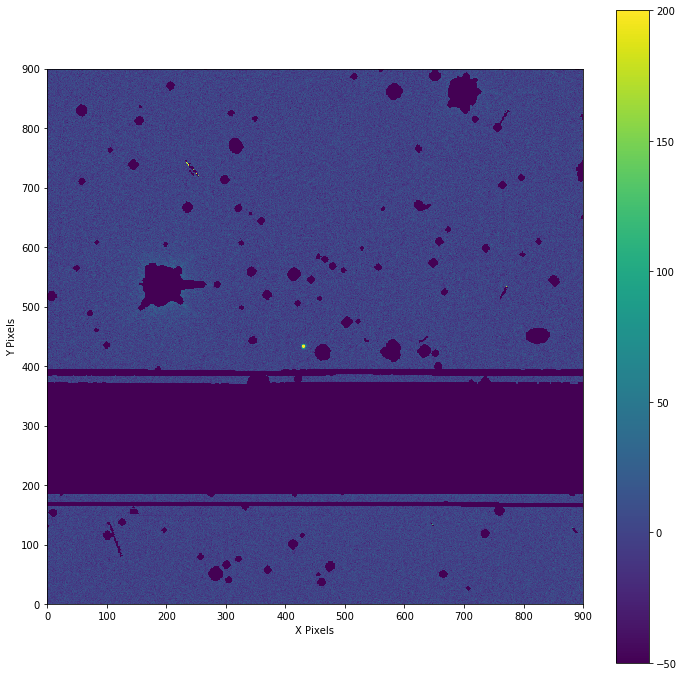

In [51]:
fig = plt.figure(figsize=(12,12))
plt.imshow(images[1] [2700:3600,2900:3800], origin='lower',  vmin=-50, vmax=200)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

In [52]:
search = kb.stack_search(stack, p)
search.set_debug(True)

In [53]:
search_ang_r = (angle_range[0]/search_margin,
                angle_range[1]*search_margin)
search_vel_r = (velocity_range[0]/search_margin,
                velocity_range[1]*search_margin)
#search.gpu(angle_steps,velocity_steps, *angle_range, *velocity_range, min_observations)

In [54]:
#search.get_results(0,20)

In [55]:
#search.region_search(2400, 1040, 50, 255, 3)
res = search.region_search(2000, 1000, 800, 60, 3)
res

[ix: 3124.000000 iy: 3043.000000 fx: 3612.000000 fy: 3254.000000 depth: 0 obs_count: 3 lh: 262.363678 flux 9595.437500,
 ix: 67.000000 iy: 878.000000 fx: 598.000000 fy: 1010.000000 depth: 0 obs_count: 4 lh: 149.268463 flux 3111.176514,
 ix: 3419.000000 iy: 1728.000000 fx: 3897.000000 fy: 1833.000000 depth: 0 obs_count: 4 lh: 143.191422 flux 2970.335938,
 ix: 437.000000 iy: 2867.000000 fx: 994.000000 fy: 3206.000000 depth: 0 obs_count: 3 lh: 126.929794 flux 8561.707031,
 ix: 2746.000000 iy: 1935.000000 fx: 2653.000000 fy: 1682.000000 depth: 0 obs_count: 3 lh: 124.127563 flux 8396.350586,
 ix: 2479.000000 iy: 2867.000000 fx: 2668.000000 fy: 2534.000000 depth: 0 obs_count: 3 lh: 119.299255 flux 7735.147949,
 ix: 1553.000000 iy: 2774.000000 fx: 2029.000000 fy: 2844.000000 depth: 0 obs_count: 4 lh: 118.487846 flux 2512.531982,
 ix: 1655.000000 iy: 2693.000000 fx: 2109.000000 fy: 2814.000000 depth: 0 obs_count: 4 lh: 106.040016 flux 2361.571289,
 ix: 2762.000000 iy: 1576.000000 fx: 3222.0000

In [56]:
matched = []
for r in res:
    if any(abs(r.ix-t.x)<=1 and abs(r.iy-t.y)<=1 for t in results_key ):
        matched.append(r)
len(matched)

9

In [57]:
matched

[ix: 3124.000000 iy: 3043.000000 fx: 3612.000000 fy: 3254.000000 depth: 0 obs_count: 3 lh: 262.363678 flux 9595.437500,
 ix: 67.000000 iy: 878.000000 fx: 598.000000 fy: 1010.000000 depth: 0 obs_count: 4 lh: 149.268463 flux 3111.176514,
 ix: 3419.000000 iy: 1728.000000 fx: 3897.000000 fy: 1833.000000 depth: 0 obs_count: 4 lh: 143.191422 flux 2970.335938,
 ix: 1553.000000 iy: 2774.000000 fx: 2029.000000 fy: 2844.000000 depth: 0 obs_count: 4 lh: 118.487846 flux 2512.531982,
 ix: 1655.000000 iy: 2693.000000 fx: 2109.000000 fy: 2814.000000 depth: 0 obs_count: 4 lh: 106.040016 flux 2361.571289,
 ix: 2762.000000 iy: 1576.000000 fx: 3222.000000 fy: 1789.000000 depth: 0 obs_count: 4 lh: 104.336205 flux 2172.297363,
 ix: 1924.000000 iy: 501.000000 fx: 2452.000000 fy: 597.000000 depth: 0 obs_count: 4 lh: 96.617958 flux 2060.263672,
 ix: 3646.000000 iy: 746.000000 fx: 4129.000000 fy: 809.000000 depth: 0 obs_count: 3 lh: 70.976974 flux 1738.445312,
 ix: 816.000000 iy: 3332.000000 fx: 1318.000000 fy

In [58]:
pooled = search.get_psi_pooled()

In [59]:
pooled_imgs = [np.array(im, copy=False) for im in pooled[1]]

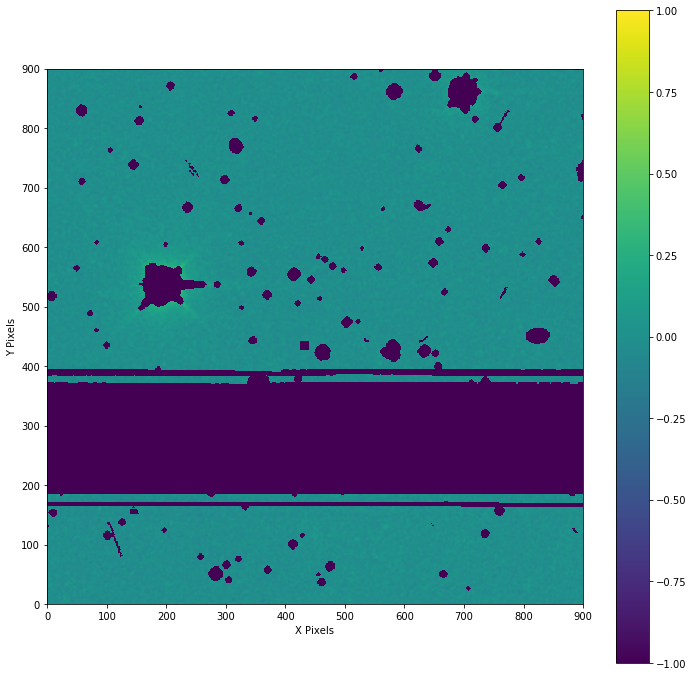

In [60]:
fig = plt.figure(figsize=(12,12))
plt.imshow(pooled_imgs[0] [2700:3600,2900:3800], origin='lower',  vmin=-1, vmax=1)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

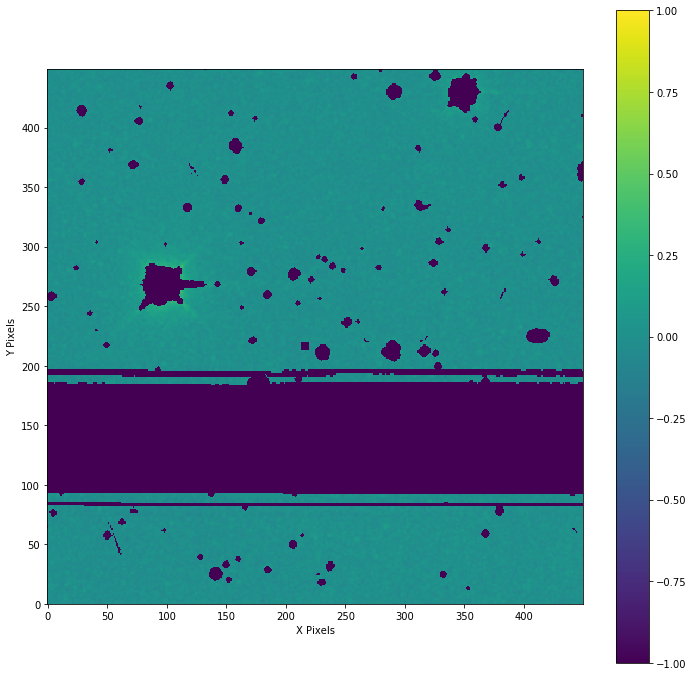

In [61]:
fig = plt.figure(figsize=(12,12))
plt.imshow(pooled_imgs[1] [1350:1800,1450:1900], origin='lower',  vmin=-1, vmax=1)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

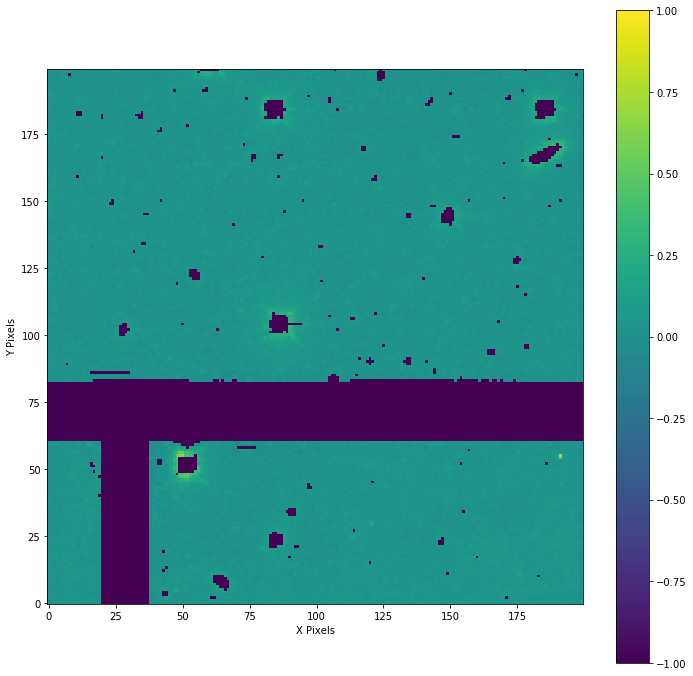

In [62]:
fig = plt.figure(figsize=(12,12))
plt.imshow(pooled_imgs[3] [300:500,300:500], origin='lower',  vmin=-1, vmax=1)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()